## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
epoch_num=50
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
import models
import metrics
device

device(type='cpu')

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
import scvi
adata = scvi.data.pbmc_dataset()
adata.var['alt_names']=adata.var_names
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

Global seed set to 0


INFO     File data/gene_info_pbmc.csv already downloaded                                                           
INFO     File data/pbmc_metadata.pickle already downloaded                                                         
INFO     File data/pbmc8k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc8k/filtered_gene_bc_matrices                                          
INFO     File data/pbmc4k/filtered_gene_bc_matrices.tar.gz already downloaded                                      
INFO     Extracting tar file                                                                                       
INFO     Removing extracted data at data/pbmc4k/filtered_gene_bc_matrices                                          


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 11990 × 3346
    obs: 'n_counts', 'batch', 'labels', 'str_labels'
    var: 'gene_symbols', 'n_counts-0', 'n_counts-1', 'n_counts', 'alt_names'
    uns: 'cell_types', 'pca', 'neighbors', 'umap'
    obsm: 'design', 'raw_qc', 'normalized_qc', 'qc_pc', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
adata.obs['str_labels'].value_counts()

CD4 T cells          4996
CD14+ Monocytes      2227
B cells              1621
CD8 T cells          1448
Other                 463
NK cells              457
FCGR3A+ Monocytes     351
Dendritic Cells       339
Megakaryocytes         88
Name: str_labels, dtype: int64

In [5]:
adata= adata[adata.obs['str_labels'].isin(['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic Cells' ,'FCGR3A+ Monocytes', 'NK cells'])]

In [6]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [7]:
adata_scaled = adata.copy()
sc.pp.scale(adata_scaled)

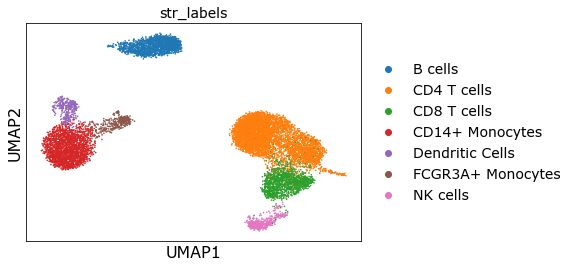

In [8]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='str_labels')

In [9]:
epoch_num=100
prob_list = models.follow_training_dyn_neural_net(adata, label_key='str_labels',iterNum=epoch_num, device=device)

/Users/jonathankarin/PycharmProjects/training_dyn/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.389
[1,    12] loss: 1.927
[1,    22] loss: 1.870
[1,    32] loss: 1.790
[1,    42] loss: 1.708
[2,     2] loss: 0.322
[2,    12] loss: 1.543
[2,    22] loss: 1.398
[2,    32] loss: 1.257
[2,    42] loss: 1.108
[3,     2] loss: 0.194
[3,    12] loss: 0.903
[3,    22] loss: 0.788
[3,    32] loss: 0.689
[3,    42] loss: 0.614
[4,     2] loss: 0.110
[4,    12] loss: 0.516
[4,    22] loss: 0.465
[4,    32] loss: 0.410
[4,    42] loss: 0.368
[5,     2] loss: 0.066
[5,    12] loss: 0.316
[5,    22] loss: 0.309
[5,    32] loss: 0.288
[5,    42] loss: 0.251
[6,     2] loss: 0.051
[6,    12] loss: 0.235
[6,    22] loss: 0.214
[6,    32] loss: 0.201
[6,    42] loss: 0.214
[7,     2] loss: 0.043
[7,    12] loss: 0.182
[7,    22] loss: 0.172
[7,    32] loss: 0.152
[7,    42] loss: 0.172
[8,     2] loss: 0.033
[8,    12] loss: 0.151
[8,    22] loss: 0.144
[8,    32] loss: 0.143
[8,    42] loss: 0.156
[9,     2] loss: 0.033
[9,    12] loss: 0.129
[9,    22] loss: 0.135
[9,    32] 

[69,    42] loss: 0.021
[70,     2] loss: 0.002
[70,    12] loss: 0.016
[70,    22] loss: 0.011
[70,    32] loss: 0.017
[70,    42] loss: 0.015
[71,     2] loss: 0.005
[71,    12] loss: 0.019
[71,    22] loss: 0.020
[71,    32] loss: 0.016
[71,    42] loss: 0.013
[72,     2] loss: 0.004
[72,    12] loss: 0.015
[72,    22] loss: 0.012
[72,    32] loss: 0.012
[72,    42] loss: 0.016
[73,     2] loss: 0.005
[73,    12] loss: 0.020
[73,    22] loss: 0.018
[73,    32] loss: 0.018
[73,    42] loss: 0.016
[74,     2] loss: 0.002
[74,    12] loss: 0.017
[74,    22] loss: 0.017
[74,    32] loss: 0.019
[74,    42] loss: 0.017
[75,     2] loss: 0.004
[75,    12] loss: 0.012
[75,    22] loss: 0.016
[75,    32] loss: 0.018
[75,    42] loss: 0.016
[76,     2] loss: 0.002
[76,    12] loss: 0.017
[76,    22] loss: 0.021
[76,    32] loss: 0.020
[76,    42] loss: 0.017
[77,     2] loss: 0.002
[77,    12] loss: 0.017
[77,    22] loss: 0.012
[77,    32] loss: 0.015
[77,    42] loss: 0.014
[78,     2] loss

In [10]:
all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)

In [11]:
cutoff_conf , cutoff_var = models.find_cutoff_paramter(adata,'str_labels',device,probability=0.05,percentile=95,epoch_num=epoch_num)

/Users/jonathankarin/PycharmProjects/training_dyn/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.388
[1,    12] loss: 1.809
[1,    22] loss: 1.597
[1,    32] loss: 1.503
[1,    42] loss: 1.430
[2,     2] loss: 0.277
[2,    12] loss: 1.277
[2,    22] loss: 1.175
[2,    32] loss: 1.063
[2,    42] loss: 1.025
[3,     2] loss: 0.187
[3,    12] loss: 0.954
[3,    22] loss: 0.858
[3,    32] loss: 0.800
[3,    42] loss: 0.766
[4,     2] loss: 0.149
[4,    12] loss: 0.722
[4,    22] loss: 0.658
[4,    32] loss: 0.655
[4,    42] loss: 0.618
[5,     2] loss: 0.130
[5,    12] loss: 0.609
[5,    22] loss: 0.565
[5,    32] loss: 0.559
[5,    42] loss: 0.530
[6,     2] loss: 0.098
[6,    12] loss: 0.476
[6,    22] loss: 0.555
[6,    32] loss: 0.516
[6,    42] loss: 0.545
[7,     2] loss: 0.087
[7,    12] loss: 0.499
[7,    22] loss: 0.478
[7,    32] loss: 0.470
[7,    42] loss: 0.511
[8,     2] loss: 0.099
[8,    12] loss: 0.469
[8,    22] loss: 0.456
[8,    32] loss: 0.463
[8,    42] loss: 0.454
[9,     2] loss: 0.091
[9,    12] loss: 0.450
[9,    22] loss: 0.446
[9,    32] 

[69,    42] loss: 0.121
[70,     2] loss: 0.026
[70,    12] loss: 0.118
[70,    22] loss: 0.111
[70,    32] loss: 0.109
[70,    42] loss: 0.114
[71,     2] loss: 0.026
[71,    12] loss: 0.108
[71,    22] loss: 0.107
[71,    32] loss: 0.106
[71,    42] loss: 0.106
[72,     2] loss: 0.019
[72,    12] loss: 0.103
[72,    22] loss: 0.099
[72,    32] loss: 0.116
[72,    42] loss: 0.111
[73,     2] loss: 0.019
[73,    12] loss: 0.101
[73,    22] loss: 0.102
[73,    32] loss: 0.106
[73,    42] loss: 0.100
[74,     2] loss: 0.022
[74,    12] loss: 0.086
[74,    22] loss: 0.098
[74,    32] loss: 0.105
[74,    42] loss: 0.102
[75,     2] loss: 0.021
[75,    12] loss: 0.080
[75,    22] loss: 0.100
[75,    32] loss: 0.101
[75,    42] loss: 0.093
[76,     2] loss: 0.017
[76,    12] loss: 0.089
[76,    22] loss: 0.096
[76,    32] loss: 0.095
[76,    42] loss: 0.095
[77,     2] loss: 0.017
[77,    12] loss: 0.083
[77,    22] loss: 0.088
[77,    32] loss: 0.095
[77,    42] loss: 0.088
[78,     2] loss

In [12]:
adata.obs["var"] = all_var.detach().numpy()
adata.obs["conf"] = all_conf.detach().numpy()

In [13]:
adata.obs['conf_binaries'] = pd.Categorical((adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var))

In [14]:
adata.obs['CellType']=adata.obs['str_labels']

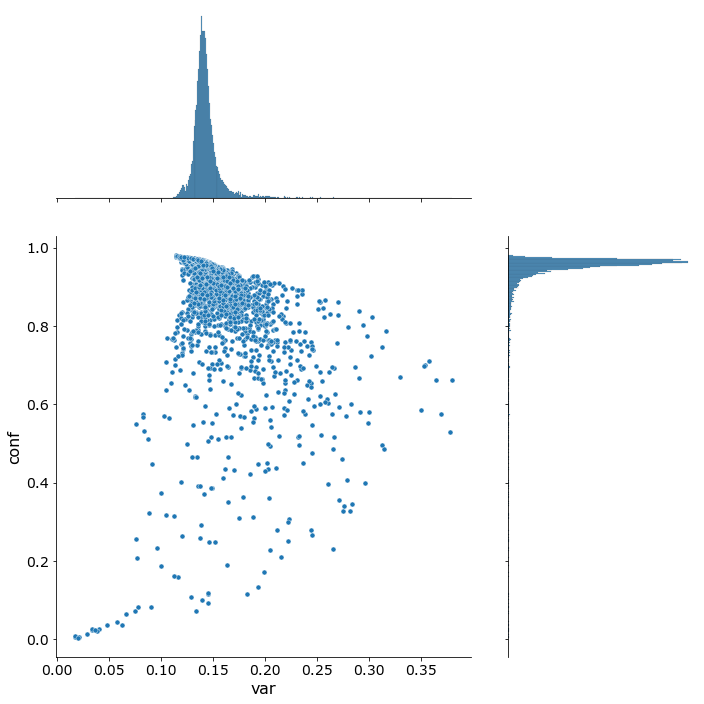

In [15]:

adata.obs['CellType']=adata.obs['str_labels']
sns.jointplot(data=adata.obs, x="var", y="conf",height=10,  s=25, ratio=2)
plt.ylabel('Confidence')
plt.xlabel('Variability')
plt.show()

In [16]:
cutoff_conf , cutoff_var

(0.4617839127779007, 0.3412339508533478)

In [17]:
adata.obs['conf_binaries'].value_counts()

True     11356
False       83
Name: conf_binaries, dtype: int64

In [18]:
sc.pp.pca(adata)#, color=['str_labels'])
sc.pp.neighbors(adata)#, color=['conf_binaries'])
sc.tl.umap(adata)#, color=['conf'])

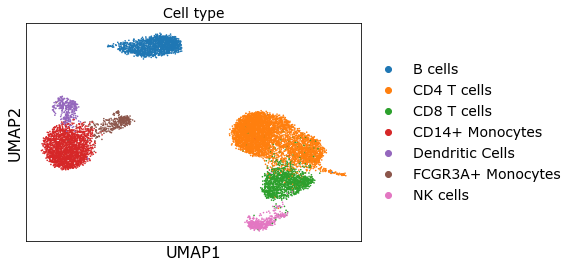

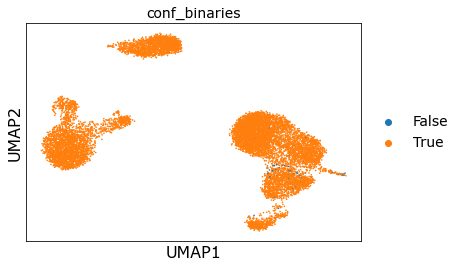

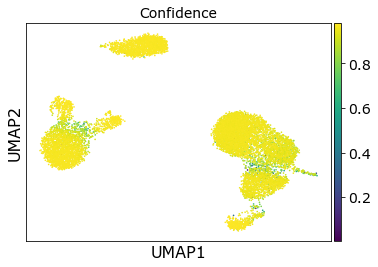

In [19]:
sc.pl.umap(adata, color=['str_labels'], title='Cell type')
sc.pl.umap(adata, color=['conf_binaries'])
sc.pl.umap(adata, color=['conf'], title='Confidence')

In [20]:
annotation_list =[]
for i in range(adata.n_obs):
    if (adata.obs['conf'][i] > cutoff_conf) | (adata.obs['var'][i] > cutoff_var):
        if (adata.obs['conf'][i] > 0.95) & (adata.obs['var'][i] < 0.15):
            annotation_list.append('Correctly annotated')
        else:
            annotation_list.append('Ambiguously annotated.')
    else:
            annotation_list.append('Erroneously annotated')

adata.obs['Annotation']=annotation_list


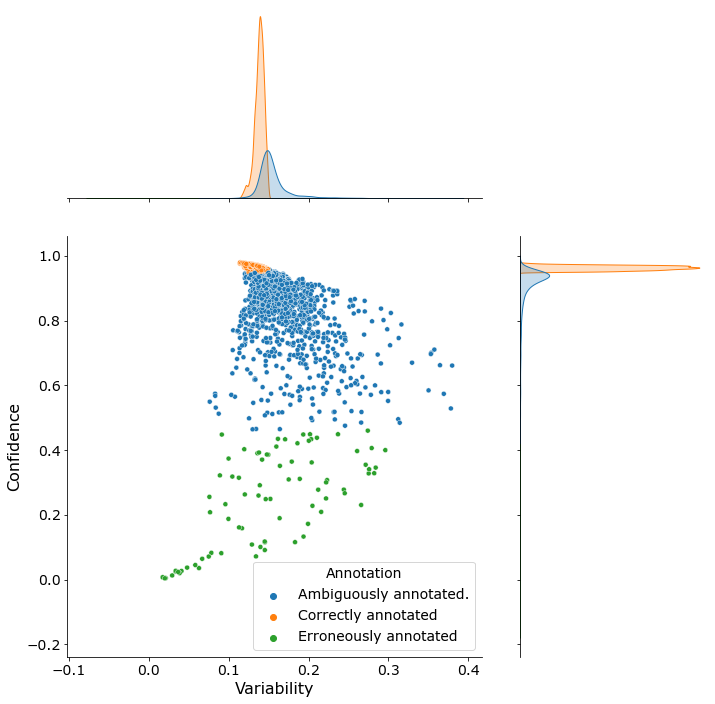

In [21]:
adata.obs['conf_non_ambiguous'] = pd.Categorical((adata.obs['conf'] > 0.95) | (adata.obs['var'] < 0.15))
adata.obs['Confidence']= adata.obs['conf']
adata.obs['Variability']= adata.obs['var']

fig = sns.jointplot(data=adata.obs, x="Variability", y="Confidence",hue='Annotation',height=10,  s=25, ratio=2)
plt.show(fig)

In [22]:
gene_mapping = {
    'ENSG00000168685': 'IL7R',
    'ENSG00000126353': 'CCR7',
    'ENSG00000196154': 'S100A4',
    'ENSG00000105369': 'CD79A',
    'ENSG00000153563': 'CD8A',
    'ENSG00000170458': 'CD14',
    'ENSG00000131981': 'LGALS3',
    'ENSG00000105374': 'NKG7',
    'ENSG00000111796': 'KLRB1',
    'ENSG00000179639': 'FCER1A',
    'ENSG00000101439': 'CST3',
    'ENSG00000163736': 'PPBP',
    'ENSG00000116824': 'CD2',
    'ENSG00000188404': 'SELL',
    'ENSG00000111537': 'IFNG',
    'ENSG00000168329': 'CX3CR1',
    'ENSG00000160255': 'ITGB2',
    'ENSG00000125498': 'KIR2DL1',
    'ENSG00000243772': 'KIR2DL3',
    'ENSG00000139187': 'KLRG1',
    'ENSG00000180644': 'PRF1',
    'ENSG00000145649': 'GZMA',
    'ENSG00000100453': 'GZMB',
    'ENSG00000163221': 'S100A12',
    'ENSG00000132965': 'ALOX5AP',
    'ENSG00000178623': 'GPR35',
    'ENSG00000019169': 'MARCO',
    'ENSG00000105371': 'ICAM4',
    'ENSG00000007312': 'CD79b',
}



/Users/jonathankarin/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


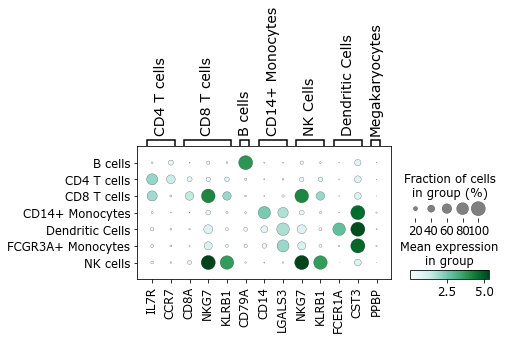

In [23]:
adata.var['alt_names'].loc['ENSG00000168685'] = 'IL7R'
adata.var['alt_names'].loc['ENSG00000126353']='CCR7'
adata.var['alt_names'].loc['ENSG00000196154']='S100A4'
adata.var['alt_names'].loc['ENSG00000105369']='CD79A'
adata.var['alt_names'].loc['ENSG00000153563']='CD8A'
adata.var['alt_names'].loc['ENSG00000170458']='CD14'
adata.var['alt_names'].loc['ENSG00000131981']='LGALS3'
adata.var['alt_names'].loc['ENSG00000105374']='NKG7'
adata.var['alt_names'].loc['ENSG00000111796']='KLRB1'
adata.var['alt_names'].loc['ENSG00000179639']='FCER1A'
adata.var['alt_names'].loc['ENSG00000101439']='CST3'
adata.var['alt_names'].loc['ENSG00000163736']='PPBP'
adata.var['alt_names'].loc['ENSG00000116824'] = 'CD2'
adata.var['alt_names'].loc['ENSG00000188404']='SELL'
adata.var['alt_names'].loc['ENSG00000111537']='IFNG'
adata.var['alt_names'].loc['ENSG00000168329']='CX3CR1'
adata.var['alt_names'].loc['ENSG00000160255']='ITGB2'
adata.var['alt_names'].loc['ENSG00000125498']='KIR2DL1'
adata.var['alt_names'].loc['ENSG00000243772']='KIR2DL3'
adata.var['alt_names'].loc['ENSG00000139187']='KLRG1'
adata.var['alt_names'].loc['ENSG00000180644']='PRF1'
adata.var['alt_names'].loc['ENSG00000145649']='GZMA'
adata.var['alt_names'].loc['ENSG00000100453']='GZMB'
adata.var['alt_names'].loc['ENSG00000163221'] = 'S100A12'
adata.var['alt_names'].loc['ENSG00000132965']='ALOX5AP'
adata.var['alt_names'].loc['ENSG00000178623']='GPR35'
adata.var['alt_names'].loc['ENSG00000019169']='MARCO'
adata.var['alt_names'].loc['ENSG00000105371']='ICAM4'
adata.var['alt_names'].loc['ENSG00000007312']='CD79b'

marker_genes_dict= {
    'CD4 T cells':['IL7R','CCR7'],
    'CD8 T cells':['CD8A','NKG7','KLRB1'],
    'B cells':['CD79A'],
    'CD14+ Monocytes':['CD14','LGALS3'],
    'NK Cells':['NKG7','KLRB1'],
    'Dendritic Cells':['FCER1A','CST3'],
    'Megakaryocytes':['PPBP']}
    

ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='str_labels', gene_symbols='alt_names', cmap='BuGn')


In [24]:
corr_classified_list =[]
for i in range(adata.n_obs):
    if adata.obs['conf_binaries'][i]==True:
        corr_classified_list.append('Correct annotation')
    else: 
        corr_classified_list.append('Erroneous annotation')
adata.obs['annotation']=corr_classified_list

Dendritic Cells


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


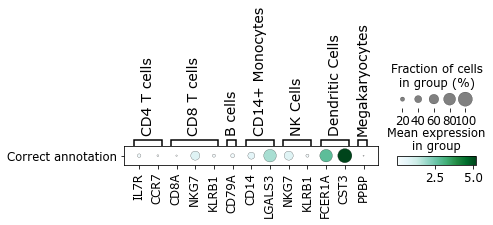

CD8 T cells


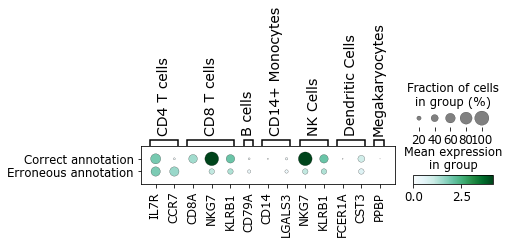

NK cells


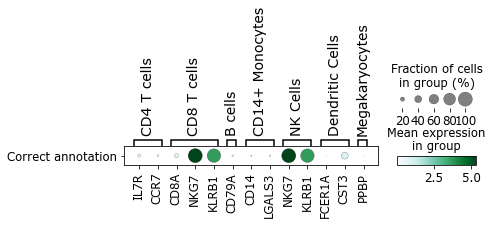

CD4 T cells


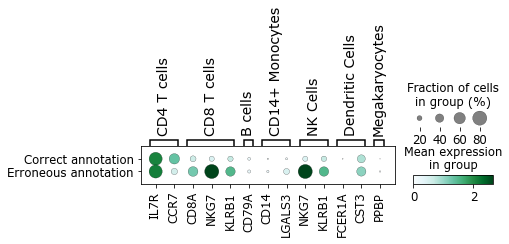

CD14+ Monocytes


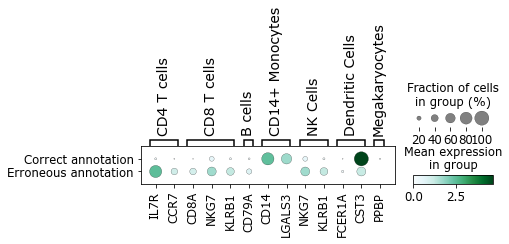

FCGR3A+ Monocytes


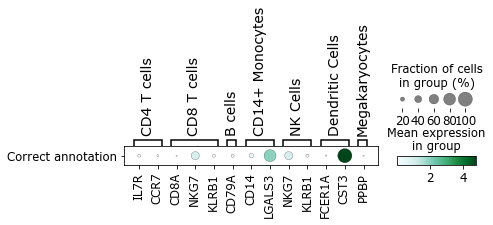

B cells


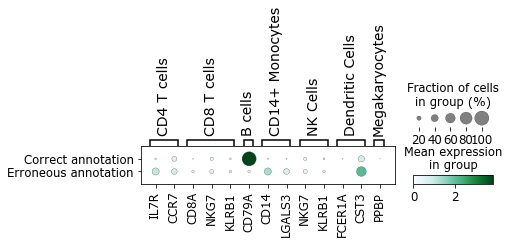

In [25]:
for celltype in set(adata.obs['str_labels']):
    adata_tmp= adata[adata.obs['str_labels'].isin([celltype])]
    print(celltype)
    
    ax = sc.pl.dotplot(adata_tmp, marker_genes_dict, groupby='annotation',cmap='BuGn', gene_symbols='alt_names')


In [26]:
adata_scaled.obs['conf']= adata.obs['conf']
adata_scaled.obs['var']= adata.obs['var']
adata_scaled.obs['conf_binaries']= adata.obs['conf_binaries']

In [27]:
cd56_genes_dict= {
    'CD56 bright':['IL7R','CCR7','CD2','SELL','IFNG'], 
    'CD56 dim':['CX3CR1','ITGB2','KIR2DL1','KIR2DL3','KLRG1','PRF1','GZMA','GZMB'],     

                   }


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/1272434542.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk_cd8.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk_cd8.obs['conf'] > 0.95) | (adata_nk_cd8.obs['var'] < 0.15))


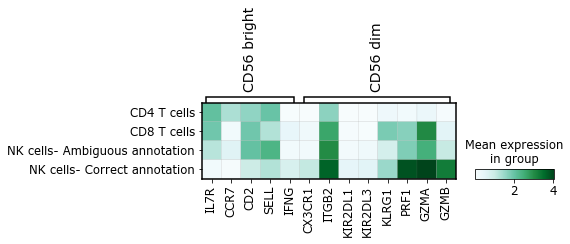

In [28]:
adata_nk_cd8= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk_cd8= adata_nk_cd8[adata_nk_cd8.obs['str_labels'].isin(['NK cells','CD8 T cells','CD4 T cells'])]


adata_nk_cd8.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk_cd8.obs['conf'] > 0.95) | (adata_nk_cd8.obs['var'] < 0.15))

corr_classified_list =[]
for i in range(adata_nk_cd8.n_obs):
    if adata_nk_cd8.obs['str_labels'][i]=='CD8 T cells':
        corr_classified_list.append('CD8 T cells')
    elif adata_nk_cd8.obs['str_labels'][i]=='CD4 T cells':
        corr_classified_list.append('CD4 T cells')
    else:
        if adata_nk_cd8.obs['conf_non_ambiguous'][i]==True:
            corr_classified_list.append('NK cells- Correct annotation')
        else: 
            corr_classified_list.append('NK cells- Ambiguous annotation')
adata_nk_cd8.obs['amb_annotation']=corr_classified_list

ax = sc.pl.matrixplot(adata_nk_cd8, cd56_genes_dict, groupby='amb_annotation',cmap='BuGn', gene_symbols='alt_names')



/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/1146249824.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))


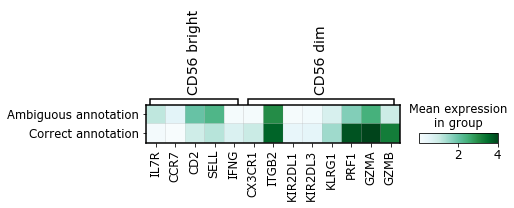

In [29]:
adata_nk= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= adata_nk[adata_nk.obs['str_labels'].isin(['NK cells'])]


adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))

corr_classified_list =[]
for i in range(adata_nk.n_obs):
    if adata_nk.obs['conf_non_ambiguous'][i]==True:
        corr_classified_list.append('Correct annotation')
    else: 
        corr_classified_list.append('Ambiguous annotation')
adata_nk.obs['amb_annotation']=corr_classified_list


adata_nk_sacled = adata_nk.copy()
#adata_nk.obs['conf_ambiguous'] = pd.Categorical(adata_nk.obs['conf'] > 0.95)
ax = sc.pl.matrixplot(adata_nk, cd56_genes_dict, groupby='amb_annotation',cmap='BuGn', gene_symbols='alt_names')



In [30]:
adata_nk.obs['conf_non_ambiguous'].value_counts()

True     410
False     47
Name: conf_non_ambiguous, dtype: int64

In [31]:
bdata= adata[adata.obs['conf_binaries'].isin([True])]
adata_nk= bdata[bdata.obs['str_labels'].isin(['NK cells'])]
adata_cd4= bdata[bdata.obs['str_labels'].isin(['CD4 T cells'])]
adata_cd8= bdata[bdata.obs['str_labels'].isin(['CD8 T cells'])]
adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))
adata_nk_cells_non_ambiguous= adata_nk[adata_nk.obs['conf_non_ambiguous'].isin([True])]
adata_nk_cells_ambiguou= adata_nk[adata_nk.obs['conf_non_ambiguous'].isin([False])]


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/2042883637.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_nk.obs['conf_non_ambiguous'] = pd.Categorical((adata_nk.obs['conf'] > 0.95) | (adata_nk.obs['var'] < 0.15))


In [32]:
mean_non_ambiguous = np.mean(adata_nk_cells_non_ambiguous.X , axis=0)
mean_ambiguous = np.mean(adata_nk_cells_ambiguou.X , axis=0)
mean_cd8 = np.mean(adata_cd8.X , axis=0)
mean_cd4 = np.mean(adata_cd4.X , axis=0)

print(np.linalg.norm(mean_non_ambiguous-mean_ambiguous))
print(np.linalg.norm(mean_non_ambiguous-mean_cd8))
print(np.linalg.norm(mean_non_ambiguous-mean_cd4))
print(np.linalg.norm(mean_cd8-mean_ambiguous))
print(np.linalg.norm(mean_cd4-mean_ambiguous))


12.250724
13.782512
20.385635
10.128641
13.586646


In [33]:
A = np.zeros((4,4))
#mean_non_ambiguous -0
#mean_ambiguous -1
#mean_cd8 -2
#mean_cd4 -3

A[0,1]= np.linalg.norm(mean_non_ambiguous-mean_ambiguous)
A[0,2]= np.linalg.norm(mean_non_ambiguous-mean_cd8)
A[0,3]= np.linalg.norm(mean_non_ambiguous-mean_cd4)
A[1,0]= A[0,1]
A[1,2]= np.linalg.norm(mean_ambiguous-mean_cd8)
A[1,3]= np.linalg.norm(mean_ambiguous-mean_cd4)
A[2,0]= A[0,2]
A[2,1]= A[1,2]
A[2,3]= np.linalg.norm(mean_cd8-mean_cd4)
A[3,0]= A[0,3]
A[3,1]= A[1,3]
A[3,2]= A[2,3]


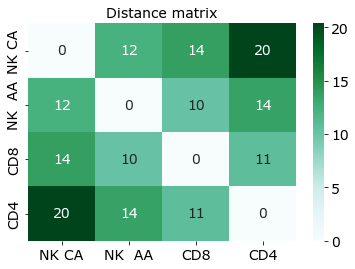

In [34]:
import seaborn as sns
g = sns.heatmap(A, annot=True,cmap='BuGn')
g.set_xticklabels(['NK CA','NK  AA','CD8','CD4'])
g.set_yticklabels(['NK CA','NK  AA','CD8','CD4'])
g.set_title('Distance matrix')
plt.show()

In [35]:
celltype_list= ["CD14+ Monocytes", "FCGR3A+ Monocytes"]#,'Dendritic Cells']
adata_monocytes= adata[adata.obs['conf_binaries'].isin([True])]
adata_monocytes= adata_monocytes[adata_monocytes.obs['str_labels'].isin(celltype_list)]
adata_monocytes_scaled= adata_scaled[adata.obs['conf_binaries'].isin([True])]
adata_monocytes_scaled= adata_monocytes_scaled[adata_monocytes_scaled.obs['str_labels'].isin(celltype_list)]
adata_monocytes_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_monocytes_scaled.obs['conf'] > 0.95) &
                                                     (adata_monocytes_scaled.obs['var'] < 0.15))


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/4083539242.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_monocytes_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_monocytes_scaled.obs['conf'] > 0.95) &


In [36]:

adata_scaled.obs['conf']=adata.obs['conf']
adata_scaled.obs['var']=adata.obs['var']

adata_cd14_scaled= adata_scaled[adata.obs['conf_binaries'].isin([True])]
adata_cd14_scaled= adata_cd14_scaled[adata_cd14_scaled.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_cd14_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_cd14_scaled.obs['conf'] > 0.95) &
                                                     (adata_cd14_scaled.obs['var'] < 0.15))

adata_fc_scaled= adata_scaled[adata.obs['conf_binaries'].isin([True])]
adata_fc_scaled= adata_fc_scaled[adata_fc_scaled.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]
adata_fc_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_fc_scaled.obs['conf'] > 0.95) &
                                                     (adata_fc_scaled.obs['var'] < 0.15))


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/3374285711.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_cd14_scaled.obs['conf'] > 0.95) &
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/3374285711.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc_scaled.obs['conf_ambiguous'] = pd.Categorical((adata_fc_scaled.obs['conf'] > 0.95) &


In [37]:
adata_cd14_scaled.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14_scaled.obs['conf'] > 0.95) | (adata_cd14_scaled.obs['var'] < 0.15))
adata_fc_scaled.obs['conf_non_ambiguous'] = pd.Categorical((adata_fc_scaled.obs['conf'] > 0.95) | (adata_fc_scaled.obs['var'] < 0.15))
adata_cd14= adata[adata.obs['str_labels'].isin(["CD14+ Monocytes"])]
adata_fc= adata[adata.obs['str_labels'].isin(["FCGR3A+ Monocytes"])]

annotation_list_cd14=[]
for i in range( adata_cd14.n_obs):
    if adata_cd14.obs['conf_non_ambiguous'][i]==True:
        annotation_list_cd14.append('Correctly classified (annotated as CD14+)')
    else:
        annotation_list_cd14.append('Intermediate state (annotated as CD14+)')
annotation_list_fc=[]
for i in range( adata_fc.n_obs):
    if adata_fc.obs['conf_non_ambiguous'][i]==True:
        annotation_list_fc.append('Correctly classified (annotated as FCGR3A+)')
    else:
        annotation_list_fc.append('Intermediate state (annotated as FCGR3A+)')
adata_cd14.obs['cell_state']=annotation_list_cd14
adata_fc.obs['cell_state']=annotation_list_fc
adata_fc_cd14= adata_cd14.concatenate(adata_fc)

sc.pp.scale(adata_fc_cd14)


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/1232663467.py:18: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['cell_state']=annotation_list_cd14
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/1232663467.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fc.obs['cell_state']=annotation_list_fc
/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


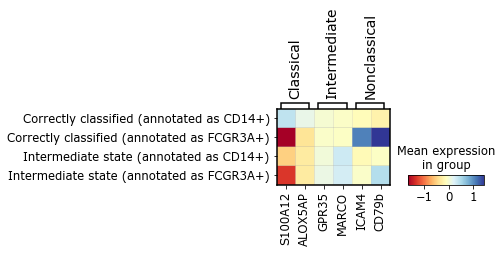

In [38]:

mono_genes_dict= {
    'Classical':['S100A12','ALOX5AP'], 
    'Intermediate':['GPR35','MARCO'], 
    'Nonclassical':['ICAM4','CD79b'], 
                   }

sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='RdYlBu', gene_symbols='alt_names')


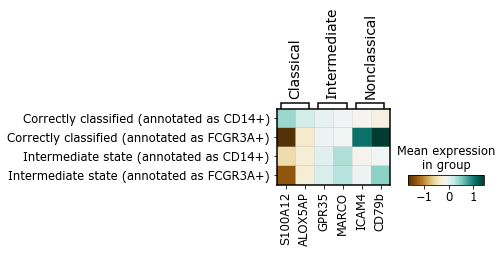

In [39]:
sc.pl.matrixplot(adata_fc_cd14, mono_genes_dict, groupby='cell_state' ,cmap='BrBG', gene_symbols='alt_names')


In [40]:
import metrics
adata_fc = metrics.rank_genes_conf(adata_fc)

adata_fc.var['conf_score_high'].sort_values(ascending=False).index[:5]

/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Index(['ENSG00000103187', 'ENSG00000158869', 'ENSG00000185201',
       'ENSG00000108518', 'ENSG00000076944'],
      dtype='object')

In [41]:
def find_conf_rank(df, gene):
    for i , j in enumerate(df.index):
        if j==gene:
            return i
find_conf_rank(adata_fc.var['conf_score_low'].sort_values(ascending=False),'ENSG00000103187')

3345

In [42]:
#adata.var['alt_names'].loc['ENSG00000163221'] = 'S100A12'
#adata.var['alt_names'].loc['ENSG00000132965']='ALOX5AP'
#adata.var['alt_names'].loc['ENSG00000178623']='GPR35'
#adata.var['alt_names'].loc['ENSG00000019169']='MARCO'
#adata.var['alt_names'].loc['ENSG00000105371']='ICAM4'
#adata.var['alt_names'].loc['ENSG00000007312']='CD79b'
mono_genes_list = ['ENSG00000163221','ENSG00000132965','ENSG00000178623','ENSG00000019169','ENSG00000105371','ENSG00000007312']
df= adata_fc.var['conf_score_low'].sort_values(ascending=False)
for gene in mono_genes_list:
    print(gene)
    print(gene_mapping[gene])

    print(find_conf_rank(df,gene))
    print("***")
    
print("high")
print()
df= adata_fc.var['conf_score_high'].sort_values(ascending=False)
for gene in mono_genes_list:
    print(gene)
    print(gene_mapping[gene])
    print(find_conf_rank(df,gene))
    print("***")


ENSG00000163221
S100A12
29
***
ENSG00000132965
ALOX5AP
102
***
ENSG00000178623
GPR35
394
***
ENSG00000019169
MARCO
108
***
ENSG00000105371
ICAM4
3294
***
ENSG00000007312
CD79b
3309
***
high

ENSG00000163221
S100A12
3316
***
ENSG00000132965
ALOX5AP
3243
***
ENSG00000178623
GPR35
2951
***
ENSG00000019169
MARCO
3237
***
ENSG00000105371
ICAM4
51
***
ENSG00000007312
CD79b
36
***


In [43]:
adata_cd14 = metrics.rank_genes_conf(adata_cd14)

df= adata_cd14.var['conf_score_low'].sort_values(ascending=False)
for gene in mono_genes_list:
    print(gene)
    print(gene_mapping[gene])
    print(find_conf_rank(df,gene))
    print("***")
    
print("high")
print()
df= adata_cd14.var['conf_score_high'].sort_values(ascending=False)
for gene in mono_genes_list:
    print(gene)
    print(gene_mapping[gene])
    print(find_conf_rank(df,gene))
    print("***")


ENSG00000163221
S100A12
3342
***
ENSG00000132965
ALOX5AP
3297
***
ENSG00000178623
GPR35
2260
***
ENSG00000019169
MARCO
589
***
ENSG00000105371
ICAM4
2518
***
ENSG00000007312
CD79b
96
***
high

ENSG00000163221
S100A12
3
***
ENSG00000132965
ALOX5AP
48
***
ENSG00000178623
GPR35
1085
***
ENSG00000019169
MARCO
2756
***
ENSG00000105371
ICAM4
827
***
ENSG00000007312
CD79b
3249
***


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [44]:
cd56_genes_dict= {
    'CD56 bright':['IL7R','CCR7','CD2','SELL','IFNG'], 
    'CD56 dim':['CX3CR1','ITGB2','KIR2DL1','KIR2DL3','KLRG1','PRF1','GZMA','GZMB'],     

                   }
nk_genes_list = ['ENSG00000168685','ENSG00000126353','ENSG00000116824','ENSG00000188404','ENSG00000111537',
                'ENSG00000168329','ENSG00000160255','ENSG00000125498','ENSG00000243772','ENSG00000139187','ENSG00000180644'
                ,'ENSG00000145649','ENSG00000100453']
#adata.var['alt_names'].loc['ENSG00000168685'] = 'IL7R'
#adata.var['alt_names'].loc['ENSG00000126353']='CCR7'
#adata.var['alt_names'].loc['ENSG00000116824'] = 'CD2'
#adata.var['alt_names'].loc['ENSG00000188404']='SELL'
#adata.var['alt_names'].loc['ENSG00000111537']='IFNG'
#adata.var['alt_names'].loc['ENSG00000168329']='CX3CR1'
#adata.var['alt_names'].loc['ENSG00000160255']='ITGB2'
#adata.var['alt_names'].loc['ENSG00000125498']='KIR2DL1'
#adata.var['alt_names'].loc['ENSG00000243772']='KIR2DL3'
#adata.var['alt_names'].loc['ENSG00000139187']='KLRG1'
#adata.var['alt_names'].loc['ENSG00000180644']='PRF1'
#adata.var['alt_names'].loc['ENSG00000145649']='GZMA'
#adata.var['alt_names'].loc['ENSG00000100453']='GZMB'
adata_nk = metrics.rank_genes_conf(adata_nk)

df= adata_nk.var['conf_score_low'].sort_values(ascending=False)
for gene in nk_genes_list:
    print(gene)
    print(gene_mapping[gene])
    print(find_conf_rank(df,gene))
    print("***")
    
print("high")
print()
df= adata_nk.var['conf_score_high'].sort_values(ascending=False)
for gene in nk_genes_list:
    print(gene)
    print(gene_mapping[gene])
    print(find_conf_rank(df,gene))
    print("***")



ENSG00000168685
IL7R
16
***
ENSG00000126353
CCR7
53
***
ENSG00000116824
CD2
71
***
ENSG00000188404
SELL
105
***
ENSG00000111537
IFNG
3276
***
ENSG00000168329
CX3CR1
3318
***
ENSG00000160255
ITGB2
3321
***
ENSG00000125498
KIR2DL1
3224
***
ENSG00000243772
KIR2DL3
3084
***
ENSG00000139187
KLRG1
2423
***
ENSG00000180644
PRF1
3344
***
ENSG00000145649
GZMA
3340
***
ENSG00000100453
GZMB
3339
***
high

ENSG00000168685
IL7R
3329
***
ENSG00000126353
CCR7
3292
***
ENSG00000116824
CD2
3274
***
ENSG00000188404
SELL
3240
***
ENSG00000111537
IFNG
69
***
ENSG00000168329
CX3CR1
27
***
ENSG00000160255
ITGB2
24
***
ENSG00000125498
KIR2DL1
121
***
ENSG00000243772
KIR2DL3
261
***
ENSG00000139187
KLRG1
922
***
ENSG00000180644
PRF1
1
***
ENSG00000145649
GZMA
5
***
ENSG00000100453
GZMB
6
***


/Users/jonathankarin/.conda/envs/spctral_jan/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [45]:
adata_nk.var['conf_score_low'].sort_values(ascending=False)[:5].index

Index(['ENSG00000177954', 'ENSG00000172005', 'ENSG00000102245',
       'ENSG00000213741', 'ENSG00000118181'],
      dtype='object')

In [46]:
intermediate_state_mapping = {
    'B cells': 'B cells',
    'CD4 T cells': 'CD4 T cells',
    'CD8 T cells': 'NK cells',
    'FCGR3A+ Monocytes': 'CD14+ Monocytes',
    'CD14+ Monocytes': 'FCGR3A+ Monocytes',
    'Dendritic Cells': 'Dendritic Cells',
    'NK cells': 'CD8 T cells'
}

# Create an empty list to store the updated cell types
cell_type_list = []
for i in range(adata.n_obs):
    cluster_name = adata.obs['str_labels'][i]
    if cluster_name in intermediate_state_mapping:
        cell_type_list.append(intermediate_state_mapping[cluster_name])
    else:
        cell_type_list.append(cluster_name)

# Update the cell type column in the AnnData object
adata.obs['str_labels_2'] = np.array(cell_type_list)
epoch_num=100
prob_list_1, prob_list_2 = models.follow_train_dyn_two_lables(adata, label_one='str_labels', label_two= 'str_labels_2', iterNum=epoch_num, device=device)

/Users/jonathankarin/PycharmProjects/training_dyn/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.390
[1,    12] loss: 1.929
[1,    22] loss: 1.870
[1,    32] loss: 1.792
[1,    42] loss: 1.703
[2,     2] loss: 0.322
[2,    12] loss: 1.532
[2,    22] loss: 1.399
[2,    32] loss: 1.255
[2,    42] loss: 1.098
[3,     2] loss: 0.195
[3,    12] loss: 0.898
[3,    22] loss: 0.784
[3,    32] loss: 0.696
[3,    42] loss: 0.616
[4,     2] loss: 0.112
[4,    12] loss: 0.520
[4,    22] loss: 0.466
[4,    32] loss: 0.410
[4,    42] loss: 0.374
[5,     2] loss: 0.074
[5,    12] loss: 0.327
[5,    22] loss: 0.295
[5,    32] loss: 0.290
[5,    42] loss: 0.257
[6,     2] loss: 0.049
[6,    12] loss: 0.229
[6,    22] loss: 0.224
[6,    32] loss: 0.204
[6,    42] loss: 0.198
[7,     2] loss: 0.044
[7,    12] loss: 0.186
[7,    22] loss: 0.190
[7,    32] loss: 0.178
[7,    42] loss: 0.161
[8,     2] loss: 0.032
[8,    12] loss: 0.154
[8,    22] loss: 0.151
[8,    32] loss: 0.149
[8,    42] loss: 0.122
[9,     2] loss: 0.023
[9,    12] loss: 0.126
[9,    22] loss: 0.141
[9,    32] 

[69,    42] loss: 0.014
[70,     2] loss: 0.002
[70,    12] loss: 0.028
[70,    22] loss: 0.014
[70,    32] loss: 0.021
[70,    42] loss: 0.024
[71,     2] loss: 0.006
[71,    12] loss: 0.013
[71,    22] loss: 0.015
[71,    32] loss: 0.017
[71,    42] loss: 0.009
[72,     2] loss: 0.004
[72,    12] loss: 0.015
[72,    22] loss: 0.010
[72,    32] loss: 0.013
[72,    42] loss: 0.012
[73,     2] loss: 0.002
[73,    12] loss: 0.012
[73,    22] loss: 0.015
[73,    32] loss: 0.012
[73,    42] loss: 0.018
[74,     2] loss: 0.005
[74,    12] loss: 0.014
[74,    22] loss: 0.019
[74,    32] loss: 0.015
[74,    42] loss: 0.016
[75,     2] loss: 0.002
[75,    12] loss: 0.015
[75,    22] loss: 0.018
[75,    32] loss: 0.019
[75,    42] loss: 0.014
[76,     2] loss: 0.002
[76,    12] loss: 0.014
[76,    22] loss: 0.012
[76,    32] loss: 0.014
[76,    42] loss: 0.013
[77,     2] loss: 0.002
[77,    12] loss: 0.017
[77,    22] loss: 0.018
[77,    32] loss: 0.017
[77,    42] loss: 0.013
[78,     2] loss

In [47]:
for i in range(100):
    adata.obs['prob1_' +str(i)] = prob_list_1[i]
    adata.obs['prob2_' +str(i)] = prob_list_2[i]


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/710060434.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs['prob2_' +str(i)] = prob_list_2[i]
/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/710060434.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs['prob1_' +str(i)] = prob_list_1[i]


In [48]:
adata_cd14= adata[adata.obs['conf_binaries'].isin([True])]
adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.95) | (adata_cd14.obs['var'] < 0.15))

adata_cd14= adata_cd14[adata_cd14.obs['str_labels'].isin(['CD14+ Monocytes'])]
adata_cd14_miss= adata[adata.obs['conf_binaries'].isin([False])]
adata_cd14_miss= adata_cd14_miss[adata_cd14_miss.obs['str_labels'].isin(['CD14+ Monocytes'])]
adata_cd14_inter= adata_cd14[adata_cd14.obs['conf_non_ambiguous'].isin([False])]
adata_cd14_cd14= adata_cd14[adata_cd14.obs['conf_non_ambiguous'].isin([True])]


/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_97038/1208168020.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cd14.obs['conf_non_ambiguous'] = pd.Categorical((adata_cd14.obs['conf'] > 0.95) | (adata_cd14.obs['var'] < 0.15))


In [49]:

prob_cd14_cd14 = []
std_cd14_cd14 = []
prob_cd14_miss = []
std_cd14_miss = []
prob_inter_cd14 = []
std_inter_cd14 = []
prob_inter_fc = []
std_inter_fc = []

for i in range(100):
    prob_cd14_cd14.append(np.mean(adata_cd14_cd14.obs['prob1_' +str(i)]))
    prob_cd14_miss.append(np.mean(adata_cd14_miss.obs['prob1_' +str(i)]))
    prob_inter_cd14.append(np.mean(adata_cd14_inter.obs['prob1_' +str(i)]))
    prob_inter_fc.append(np.mean(adata_cd14_inter.obs['prob2_' +str(i)]))
    std_cd14_cd14.append(np.std(adata_cd14_cd14.obs['prob1_' +str(i)]))
    std_cd14_miss.append(np.std(adata_cd14_miss.obs['prob1_' +str(i)]))
    std_inter_cd14.append(np.std(adata_cd14_inter.obs['prob1_' +str(i)]))
    std_inter_fc.append(np.std(adata_cd14_inter.obs['prob2_' +str(i)]))



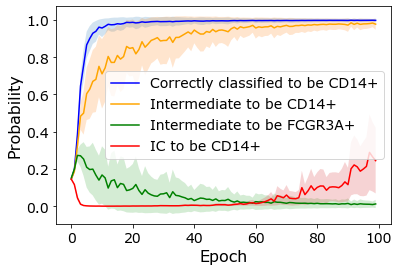

In [50]:
std_cd14_cd14 = np.array(std_cd14_cd14)
prob_cd14_cd14  = np.array(prob_cd14_cd14)
prob_inter_cd14 = np.array(prob_inter_cd14)
std_inter_cd14 = np.array(std_inter_cd14)
prob_inter_fc = np.array(prob_inter_fc)
std_inter_fc = np.array(std_inter_fc)
prob_cd14_miss = np.array(prob_cd14_miss)
std_cd14_miss = np.array(std_cd14_miss)

plt.plot(range(100),prob_cd14_cd14[:100],label='Correctly classified to be CD14+', color='b')
plt.fill_between(range(100), prob_cd14_cd14-std_cd14_cd14, prob_cd14_cd14+std_cd14_cd14, interpolate=True, alpha=0.2)
plt.plot(range(100),prob_inter_cd14[:100], label='Intermediate to be CD14+', color='orange')
plt.fill_between(range(100), prob_inter_cd14-std_inter_cd14, prob_inter_cd14+std_inter_cd14, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_inter_fc[:100], label='Intermediate to be FCGR3A+', color='g')
plt.fill_between(range(100), prob_inter_fc-std_inter_fc, prob_inter_fc+std_inter_fc, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_cd14_miss[:100], label='IC to be CD14+', color='r')
plt.fill_between(range(100), prob_cd14_miss-std_cd14_miss, prob_cd14_miss+std_cd14_miss, interpolate=True,  alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.legend()
plt.show()



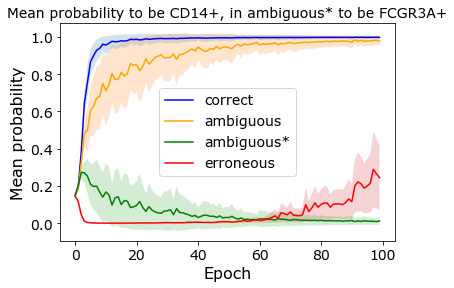

In [51]:
plt.plot(range(100),prob_cd14_cd14[:100],label='correct', color='b')
plt.fill_between(range(100), prob_cd14_cd14-std_cd14_cd14, prob_cd14_cd14+std_cd14_cd14, interpolate=True, alpha=0.2)
plt.plot(range(100),prob_inter_cd14[:100], label='ambiguous', color='orange')
plt.fill_between(range(100), prob_inter_cd14-std_inter_cd14, prob_inter_cd14+std_inter_cd14, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_inter_fc[:100], label='ambiguous*', color='g')
plt.fill_between(range(100), prob_inter_fc-std_inter_fc, prob_inter_fc+std_inter_fc, interpolate=True,  alpha=0.2)
plt.plot(range(100),prob_cd14_miss[:100], label='erroneous', color='r')
plt.fill_between(range(100), prob_cd14_miss-std_cd14_miss, prob_cd14_miss+std_cd14_miss, interpolate=True,  alpha=0.2)
plt.xlabel('Epoch')
plt.title('Mean probability to be CD14+, in ambiguous* to be FCGR3A+')
plt.ylabel('Mean probability')
#plt.ylabel(' mean probability to be classical (CD14+), except in ambiguous*, it is the probability to be non-classical (FCGR3A+)')
plt.legend()
plt.show()

